### Auxiliar Functions

In [29]:
import os
import re
import numpy as np
import random
import subprocess
import matplotlib.pyplot as plt

def print_red(text):
    print('\x1b[31m' + text + '\x1b[0m')
def print_yellow(text):
    print('\x1b[33m' + text + '\x1b[0m')
def print_green(text):
    print('\x1b[32m' + text + '\x1b[0m')
def print_pink(text):
    print('\x1b[35m' + text + '\x1b[0m')
def print_cyan(text):
    print('\x1b[36m' + text + '\x1b[0m')

## Get the Instances / Ingredient list
The instances have been generated using the notebook: Generate Instance.ipynb

In [30]:
instances_folder = '..\instances'
instances_path = [os.path.join(instances_folder, f) for f in os.listdir(instances_folder) if f.endswith('.dzn')]
# Sort
def numeric_sort_key(file_path):
    match = re.search(r'\d+', file_path)
    return int(match.group()) if match else file_path

instances_path = sorted(instances_path, key=numeric_sort_key)
instances = instances_path
# print(instances_path)

# Minizinc
### Chosen model with annotations
The models have been generated using the notebook: GenerateAnnotations.ipynb

In [31]:
models = ['../models/largest-indomain_max.mzn']# ../models/largest-indomain_max.mzn'

### Solvers

In [32]:
!minizinc --solvers
solvers = ["HiGHS", "COIN-BC", "OR-TOOLS"]

MiniZinc driver.
Available solver configurations:
  Chuffed 0.12.0 (org.chuffed.chuffed, cp, lcg, int)
  COIN-BC 2.10.10/1.17.8 (org.minizinc.mip.coin-bc, mip, float, api, osicbc, coinbc, cbc)
  CPLEX <unknown version> (org.minizinc.mip.cplex, mip, float, api)
  findMUS 0.7.0 (org.minizinc.findmus)
  Gecode 6.3.0 (org.gecode.gecode, default solver, cp, int, float, set, restart)
  Gecode Gist 6.3.0 (org.gecode.gist, cp, int, float, set, restart)
  Globalizer 0.1.7.2 (org.minizinc.globalizer, experimental, tool)
  Gurobi <unknown version> (org.minizinc.mip.gurobi, mip, float, api)
  HiGHS 1.5.1 (org.minizinc.mip.highs, mip, float, api, highs)
  OR-TOOLS 9.6.0 (com.google.or-tools)
  PicatSAT 3.4 (picat)
  SCIP <unknown version> (org.minizinc.mip.scip, mip, float, api)
  Xpress <unknown version> (org.minizinc.mip.xpress, mip, float, api)
Search path for solver configurations:
  C:\Users\juanj\AppData\Roaming/MiniZinc/solvers
  C:\Program Files\MiniZinc\share\minizinc/solvers


## Calculate labels

In [33]:
# Returns the solver who solved the model in the best way possible
def get_labels(instances, timeout_mzn):    
    winner = [0] * len(instances) # 0 for HiGHS, 1 for COIN-BC
    times = []
    timeout_mzn = timeout_mzn*1000
    
    for i, instance in enumerate(instances):
        mnt = float('inf')
        time = float('inf')
        times.append([])
        
        for j, solver in enumerate(solvers):
            for k, model in enumerate(models):
                # Run the minizinc command for the current model and data file
                # cmd = "minizinc --solver PicatSAT --output-time ../models/largest-indomain_max.mzn ../instances/1.dzn --output-time --solver-time-limit 5000 > output.txt"
                
                cmd = f"minizinc --solver {solver} --output-time {model} {instance} --output-time --solver-time-limit {timeout_mzn} > output.txt"
                proc = subprocess.Popen(cmd, stdout=subprocess.PIPE, shell=True)
                try:
                    # Wait for the process to finish
                    proc.wait()  # Optional, wait for the process to fully complete

                except KeyboardInterrupt:
                    # print_red("Program interrupted by the user.")
                    # Terminate the process
                    if os.name == 'nt': # If the os is Windows
                        subprocess.call(['taskkill', '/F', '/T', '/PID', str(proc.pid)]) # Force kill the process
                    else:
                        os.killpg(os.getpgid(proc.pid), signal.SIGTERM) # Kill the process group

                output = ""
                # Read the contents of the output.txt file
                with open("output.txt", "r") as file:
                    output = file.read()

                # Find the last occurrence of 'mnt' in the contents
                last_mnt_index = output.rfind("mnt")

                if last_mnt_index != -1:
                    # Extract the value of mnt after the last occurrence
                    solved = output[last_mnt_index:].split("=")[1].strip()
                    # Extracting the values using regular expressions
                    mnt_temp_match = re.search(r"\d+", solved)
                    time_temp_match = re.search(r"(\d+\.\d+)", solved)

                    # Storing the extracted values in variables
                    mnt_temp = float(mnt_temp_match.group())
                    time_temp = float(time_temp_match.group())
                else:
                    mnt_temp = float('inf')
                    time_temp = float('inf')
                    # print("No 'mnt' value found in the file.")                

                # Store values for futures generations
                times[i].append(time_temp)

                if mnt >= mnt_temp: # If the value is minor from the stored
                    if mnt == mnt_temp: # If the value is equal from the stored compare time
                        if time >= time_temp: # If the value of time from minizinc is minor from the stored
                            if time == time_temp: # If the value of time from minizinc is equal from the stored choose random
                                if winner[i] == 0:
                                    winner[i] = solver + '/' + model.replace("../models/", "").replace(".mzn", "")
                                if random.random() < 0.5:
                                    winner[i] = solver + '/' + model.replace("../models/", "").replace(".mzn", "")
                            else:
                                mnt = mnt_temp
                                time = time_temp
                                winner[i] = solver + '/' + model.replace("../models/", "").replace(".mzn", "")
                    else:
                        mnt = mnt_temp
                        time = time_temp
                        winner[i] = solver + '/' + model.replace("../models/", "").replace(".mzn", "")
                        
        print_yellow(str(i)+ ": " + winner[i] + " WON!")
        
    times = np.array(times)
    # Remove inf    
    def replace_inf_with_max(arr):
        # Replace inf values with nan
        arr[np.isinf(arr)] = np.nan
        max_vals = np.nanmax(arr, axis=0)  # Compute maximum values of each column
        print(max_vals)
        for i in range(arr.shape[0]):
            for j in range(arr.shape[1]):
                if np.isnan(arr[i, j]):
                    # arr[i, j] = max_vals[j]
                    arr[i, j] = timeout_mzn/1000
                if arr[i, j] > 10:
                    # arr[i, j] = max_vals[j]
                    arr[i, j] = timeout_mzn/1000
        return arr

    return winner, replace_inf_with_max(times)

In [34]:
labels, times = get_labels(instances_path, 10)

0: HiGHS/largest-indomain_max WON!
1: COIN-BC/largest-indomain_max WON!
2: HiGHS/largest-indomain_max WON!
3: COIN-BC/largest-indomain_max WON!
4: COIN-BC/largest-indomain_max WON!
5: COIN-BC/largest-indomain_max WON!
6: HiGHS/largest-indomain_max WON!
7: COIN-BC/largest-indomain_max WON!
8: COIN-BC/largest-indomain_max WON!
9: COIN-BC/largest-indomain_max WON!
10: COIN-BC/largest-indomain_max WON!
11: COIN-BC/largest-indomain_max WON!
12: COIN-BC/largest-indomain_max WON!
13: COIN-BC/largest-indomain_max WON!
14: COIN-BC/largest-indomain_max WON!
15: COIN-BC/largest-indomain_max WON!
16: HiGHS/largest-indomain_max WON!
17: HiGHS/largest-indomain_max WON!
18: COIN-BC/largest-indomain_max WON!
19: COIN-BC/largest-indomain_max WON!
20: HiGHS/largest-indomain_max WON!
21: COIN-BC/largest-indomain_max WON!
22: COIN-BC/largest-indomain_max WON!
23: COIN-BC/largest-indomain_max WON!
24: HiGHS/largest-indomain_max WON!
25: COIN-BC/largest-indomain_max WON!
26: COIN-BC/largest-indomain_max WON

In [35]:
def undersampling(category, minimum, instances, labels, times):
  under_instances = []
  under_labels = []
  under_times = []
  count = 0

  for i, label in enumerate(labels):
    if label == category:
      if count < minimum:
        under_instances.append(instances[i])
        under_labels.append(label)
        under_times.append(times[i])
        count += 1
    else:
      under_instances.append(instances[i])
      under_labels.append(label)
      under_times.append(times[i])

  return under_instances, under_labels, np.array(under_times)

#  Count the occurrences of each category
unique_categories, category_counts = np.unique(labels, return_counts=True)

# Remove the excess the category counts
for category, count in zip(unique_categories, category_counts):
    print(f"{category}: {count}")
    ## instances, labels, times = undersampling(category, min(category_counts), instances, labels, times)

print(instances, labels, times)

COIN-BC/largest-indomain_max: 64
HiGHS/largest-indomain_max: 35
OR-TOOLS/largest-indomain_max: 1
['..\\instances\\0.dzn', '..\\instances\\1.dzn', '..\\instances\\2.dzn', '..\\instances\\3.dzn', '..\\instances\\4.dzn', '..\\instances\\5.dzn', '..\\instances\\6.dzn', '..\\instances\\7.dzn', '..\\instances\\8.dzn', '..\\instances\\9.dzn', '..\\instances\\10.dzn', '..\\instances\\11.dzn', '..\\instances\\12.dzn', '..\\instances\\13.dzn', '..\\instances\\14.dzn', '..\\instances\\15.dzn', '..\\instances\\16.dzn', '..\\instances\\17.dzn', '..\\instances\\18.dzn', '..\\instances\\19.dzn', '..\\instances\\20.dzn', '..\\instances\\21.dzn', '..\\instances\\22.dzn', '..\\instances\\23.dzn', '..\\instances\\24.dzn', '..\\instances\\25.dzn', '..\\instances\\26.dzn', '..\\instances\\27.dzn', '..\\instances\\28.dzn', '..\\instances\\29.dzn', '..\\instances\\30.dzn', '..\\instances\\31.dzn', '..\\instances\\32.dzn', '..\\instances\\33.dzn', '..\\instances\\34.dzn', '..\\instances\\35.dzn', '..\\instanc

In [36]:
import shutil

balance_folder = '../instances/balance/'

for instance in instances:
    shutil.copy(instance, balance_folder)

In [37]:
folder_path = balance_folder
# Get the list of file names and sort them
file_names = [filename for filename in os.listdir(folder_path) if filename.endswith('.dzn')]
file_names.sort(key=lambda x: int(x.split('.')[0]))

print(file_names)

# Iterate over the sorted file names
for index, filename in enumerate(file_names):
    original_file_path = os.path.join(folder_path, filename)
    new_file_name = str(index) + '.dzn'
    new_file_path = os.path.join(folder_path, new_file_name)
    
    # Rename the file
    os.rename(original_file_path, new_file_path)


['0.dzn', '1.dzn', '2.dzn', '3.dzn', '4.dzn', '5.dzn', '6.dzn', '7.dzn', '8.dzn', '9.dzn', '10.dzn', '11.dzn', '12.dzn', '13.dzn', '14.dzn', '15.dzn', '16.dzn', '17.dzn', '18.dzn', '19.dzn', '20.dzn', '21.dzn', '22.dzn', '23.dzn', '24.dzn', '25.dzn', '26.dzn', '27.dzn', '28.dzn', '29.dzn', '30.dzn', '31.dzn', '32.dzn', '33.dzn', '34.dzn', '35.dzn', '36.dzn', '37.dzn', '38.dzn', '39.dzn', '40.dzn', '41.dzn', '42.dzn', '43.dzn', '44.dzn', '45.dzn', '46.dzn', '47.dzn', '48.dzn', '49.dzn', '50.dzn', '51.dzn', '52.dzn', '53.dzn', '54.dzn', '55.dzn', '56.dzn', '57.dzn', '58.dzn', '59.dzn', '60.dzn', '61.dzn', '62.dzn', '63.dzn', '64.dzn', '65.dzn', '66.dzn', '67.dzn', '68.dzn', '69.dzn', '70.dzn', '71.dzn', '72.dzn', '73.dzn', '74.dzn', '75.dzn', '76.dzn', '77.dzn', '78.dzn', '79.dzn', '80.dzn', '81.dzn', '82.dzn', '83.dzn', '84.dzn', '85.dzn', '86.dzn', '87.dzn', '88.dzn', '89.dzn', '90.dzn', '91.dzn', '92.dzn', '93.dzn', '94.dzn', '95.dzn', '96.dzn', '97.dzn', '98.dzn', '99.dzn']


## Storing labels and times

In [38]:
path = '../instances/balance/labels.txt'
with open(path, 'w', encoding='utf8') as file_object:
    file_object.write(str(labels))

path = '../instances/balance/times.txt'
with open(path, 'w', encoding='utf8') as file_object:
    file_object.write('solvers:\n'+str(solvers)+'\nannotations:\n'+str(models)+'\nTimes that took each solver with a timeout of 10s for each instance.\nIf 20s then it didnt find answer in 10s so reached cmd timeout.\n(Values greater than 10s and less than 20 was because minizinc was looking for a last solution).\n'+str(times.tolist()))

## Looking for a Patern

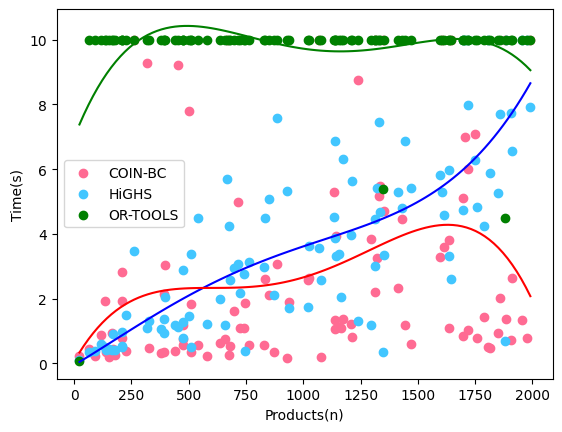

In [39]:
import ast
path = '../instances/balance/times.txt'
with open(path, 'r', encoding='utf8') as file_object:
    times = np.array(ast.literal_eval(file_object.read().split('solution).\n')[1]))

# Get n
n = []
for instance in instances:   
    with open(instance, encoding="utf8") as file_object:
        n_temp = file_object.read().split("n = ")
        n_temp = n_temp[1].split(";")
        n.append(int(n_temp[0]))
    
YH = times[:,0]
YC = times[:,1]
YO = times[:,2]

# Calculate the coefficients of the polynomial trend line
coefficientsYH = np.polyfit(n, YH, 4)
coefficientsYC = np.polyfit(n, YC, 4)
coefficientsYO = np.polyfit(n, YO, 4)

# Create a polynomial function based on the coefficients
trend_funcYH = np.poly1d(coefficientsYH)
trend_funcYC = np.poly1d(coefficientsYC)
trend_funcYO = np.poly1d(coefficientsYO)
# Generate a range of x-values for plotting the trend line
n_range = np.linspace(min(n), max(n), 100)

# Create a line plot for y2 with red color
plt.scatter(n, YC, color='#ff6b93', label=solvers[1])
# Create a line plot for y1 with blue color
plt.scatter(n, YH, color='#42c6ff', label=solvers[0])   
# Create a line plot for y1 with blue color
plt.scatter(n, YO, color='green', label=solvers[2])   


# Plot the trend line
plt.plot(n_range, trend_funcYH(n_range), color='blue')
plt.plot(n_range, trend_funcYC(n_range), color='red')
plt.plot(n_range, trend_funcYO(n_range), color='green')

# Set labels for x-axis and y-axis
plt.xlabel('Products(n)')
plt.ylabel('Time(s)')

# Set title for the plot
# plt.title('Algorithms solving instances in 10s')

# Add a legend to differentiate lines
plt.legend()

# Show the plot
plt.show()

In [40]:
freq = {}

# Count frequency of each element in the array
for num in labels:
    if num in freq:
        freq[num] += 1
    else:
        freq[num] = 1

# Print frequency of each element
for num, count in freq.items():
    print(f"{num}: {count} {count/len(labels)*100}%")

HiGHS/largest-indomain_max: 35 35.0%
COIN-BC/largest-indomain_max: 64 64.0%
OR-TOOLS/largest-indomain_max: 1 1.0%


In [41]:
print(labels)

['HiGHS/largest-indomain_max', 'COIN-BC/largest-indomain_max', 'HiGHS/largest-indomain_max', 'COIN-BC/largest-indomain_max', 'COIN-BC/largest-indomain_max', 'COIN-BC/largest-indomain_max', 'HiGHS/largest-indomain_max', 'COIN-BC/largest-indomain_max', 'COIN-BC/largest-indomain_max', 'COIN-BC/largest-indomain_max', 'COIN-BC/largest-indomain_max', 'COIN-BC/largest-indomain_max', 'COIN-BC/largest-indomain_max', 'COIN-BC/largest-indomain_max', 'COIN-BC/largest-indomain_max', 'COIN-BC/largest-indomain_max', 'HiGHS/largest-indomain_max', 'HiGHS/largest-indomain_max', 'COIN-BC/largest-indomain_max', 'COIN-BC/largest-indomain_max', 'HiGHS/largest-indomain_max', 'COIN-BC/largest-indomain_max', 'COIN-BC/largest-indomain_max', 'COIN-BC/largest-indomain_max', 'HiGHS/largest-indomain_max', 'COIN-BC/largest-indomain_max', 'COIN-BC/largest-indomain_max', 'HiGHS/largest-indomain_max', 'COIN-BC/largest-indomain_max', 'COIN-BC/largest-indomain_max', 'COIN-BC/largest-indomain_max', 'COIN-BC/largest-indoma

In [42]:
def print_numbers_with_index(lst):
    for i, num in enumerate(lst):
        if(num == 0):
            print(f"Index {i}: {num}")

# Example usage
numbers = [21, 11, 11, 21, 21, 21, 21, 11, 11, 21, 11, 11, 21, 21, 21, 11, 11, 11, 11, 21, 11, 21, 21, 11, 21, 21, 21, 11, 21, 21, 21, 21, 21, 21, 11, 21, 21, 11, 21, 11, 21, 21, 11, 11, 11, 21, 11, 21, 11, 11, 11, 11, 11, 11, 11, 21, 11, 11, 21, 21, 11, 11, 21, 21, 21, 21, 21, 11, 11, 21, 11, 11, 21, 11, 11, 21, 21, 11, 11, 21, 21, 11, 11, 11, 11, 11, 11, 21, 11, 11, 21, 11, 21, 11, 11, 21, 11, 11, 21, 21, 11, 21, 21, 11, 21, 21, 11, 11, 21, 11, 21, 21, 21, 11, 21, 11, 21, 21, 11, 21, 11, 0, 21, 21, 21, 11, 11, 21, 11, 21, 21, 21, 11, 11, 11, 21, 11, 11, 21, 21, 21, 11, 21, 21, 21, 11, 11, 21, 21, 21]
print_numbers_with_index(numbers)


Index 121: 0
